# Bird Flu Outbreak Clustering Analysis
This notebook consolidates all steps for clustering analysis on bird flu outbreak data using K-means clustering.

In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [36]:
# Load and prepare data
# Load geographic data
geo_data = pd.read_csv('./Data/geo-data.csv')

# Load and clean mammals data
hpai_mammals = pd.read_csv('./Data/hpai-mammals.csv')
hpai_mammals = hpai_mammals[['State', 'County', 'Outbreak Date']]
hpai_mammals['Outbreak Date'] = pd.to_datetime(hpai_mammals['Outbreak Date'])

# Load wild birds data
hpai_wild_birds = pd.read_csv('./Data/hpai-wild-birds1.csv')
hpai_wild_birds['Outbreak Date'] = pd.to_datetime(hpai_wild_birds['Outbreak Date'])

# Load flocks data
hpai_flocks = pd.read_csv('./Data/hpai-flocks.csv')
hpai_flocks['Outbreak Date'] = pd.to_datetime(hpai_flocks['Outbreak Date'])

In [37]:
# Clean and combine outbreak datasets
def prepare_outbreak_data(df):
    return df[['State', 'County', 'Outbreak Date']].dropna()  # Remove rows with missing data

# Combine datasets that have complete location information
outbreak_dfs = []
for df in [hpai_mammals, hpai_wild_birds, hpai_flocks]:
    if 'State' in df.columns and 'County' in df.columns:
        outbreak_dfs.append(prepare_outbreak_data(df))

combined_outbreaks = pd.concat(outbreak_dfs, ignore_index=True)

# Merge with geo_data
outbreak_locations = combined_outbreaks.merge(
    geo_data[['County', 'State', 'Longitude', 'Latitude']].drop_duplicates(),
    on=['County', 'State'],
    how='inner'
)

In [38]:
# Calculate inertia (within-cluster sum of squares) for different k values
inertias = []
K = range(1, 11)  # Test k values from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow Method For Optimal k')

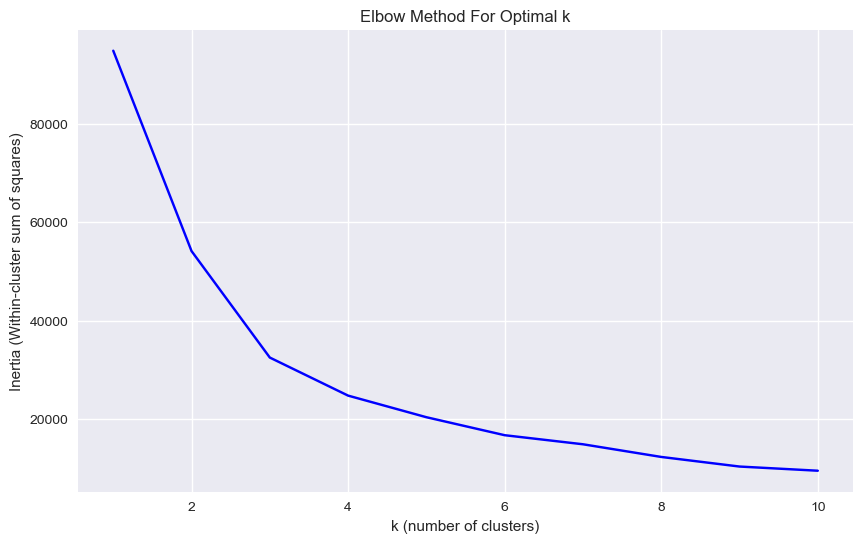

In [39]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method For Optimal k')

In [40]:
inertia_decreases = np.diff(inertias) / np.array(inertias[:-1]) * 100
print("\
Percentage decrease in inertia for each k:")
for k, decrease in enumerate(inertia_decreases, start=2):
    print(f"k={k}: {abs(decrease):.2f}% decrease")

Percentage decrease in inertia for each k:
k=2: 42.89% decrease
k=3: 39.92% decrease
k=4: 23.75% decrease
k=5: 17.67% decrease
k=6: 17.88% decrease
k=7: 10.98% decrease
k=8: 17.23% decrease
k=9: 15.77% decrease
k=10: 8.15% decrease


In [41]:
# Prepare features for clustering
X = outbreak_locations[['Longitude', 'Latitude']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering with 5 clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
outbreak_locations['Cluster'] = kmeans.fit_predict(X_scaled)

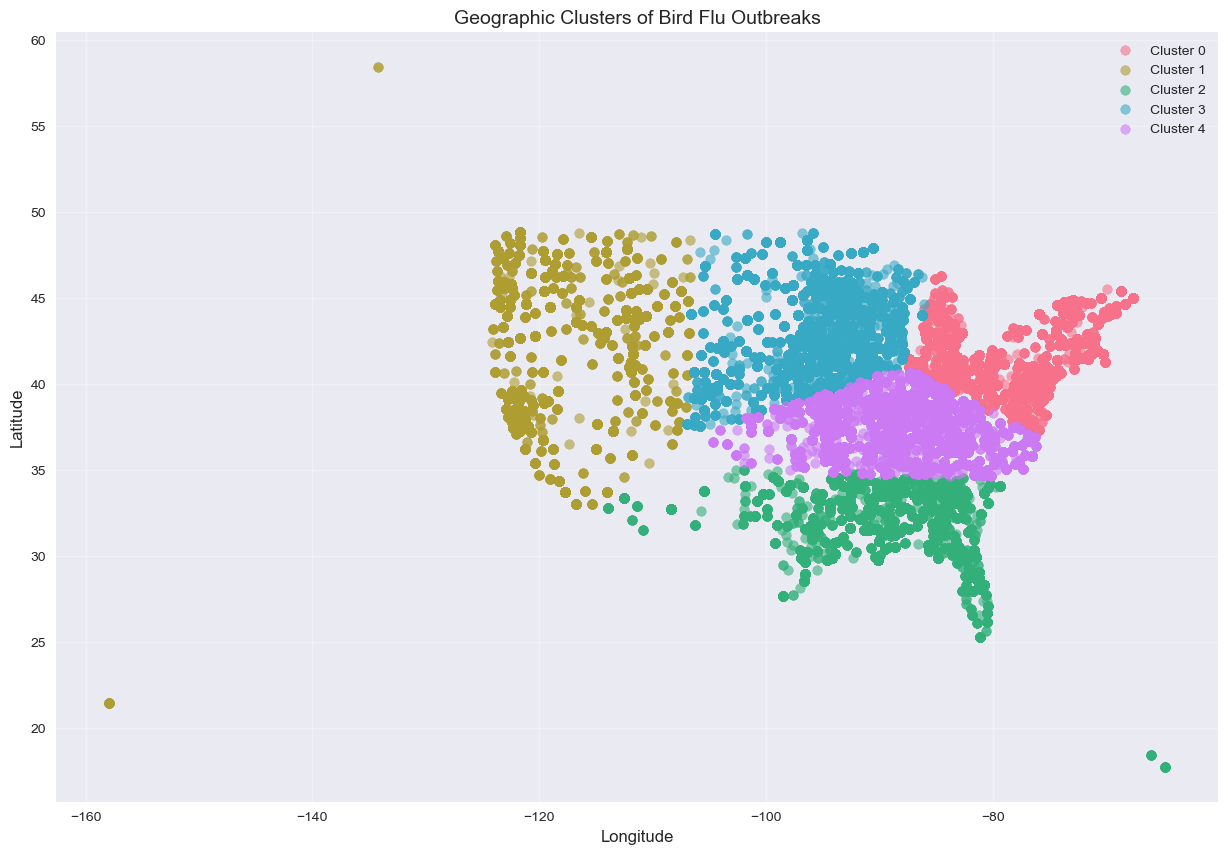

In [42]:
# Set up the plotting style
plt.style.use('seaborn-v0_8')
colors = sns.color_palette('husl', n_colors=n_clusters)

# 1. Geographic Distribution of Clusters
plt.figure(figsize=(15, 10))
for i in range(n_clusters):
    cluster_data = outbreak_locations[outbreak_locations['Cluster'] == i]
    plt.scatter(cluster_data['Longitude'], 
                cluster_data['Latitude'], 
                c=[colors[i]], 
                label=f'Cluster {i}',
                alpha=0.6)

plt.title('Geographic Clusters of Bird Flu Outbreaks', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

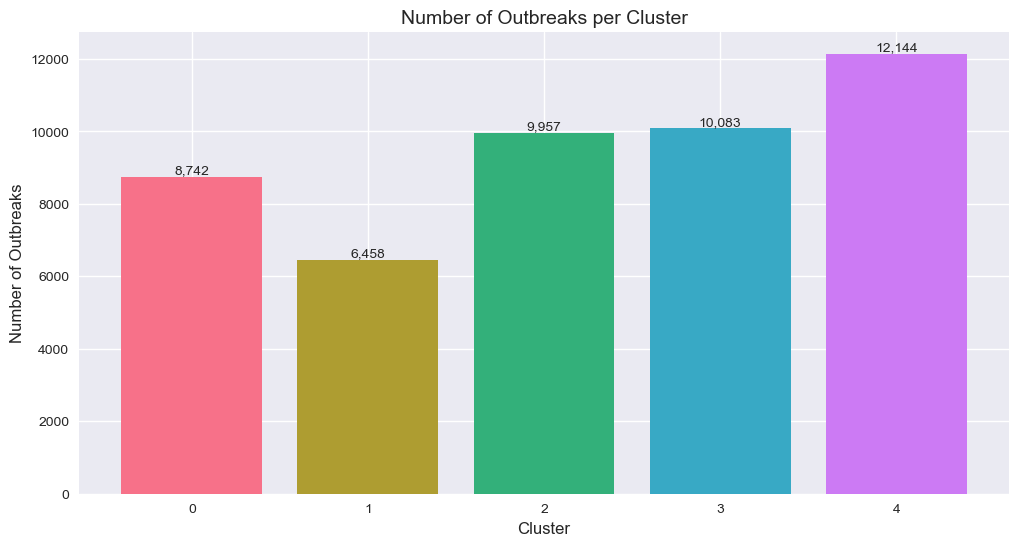

In [43]:
# 2. Cluster Size Distribution
cluster_sizes = outbreak_locations['Cluster'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
bars = plt.bar(range(n_clusters), cluster_sizes, color=colors)
plt.title('Number of Outbreaks per Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Outbreaks', fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

plt.show()

<Figure size 1500x800 with 0 Axes>

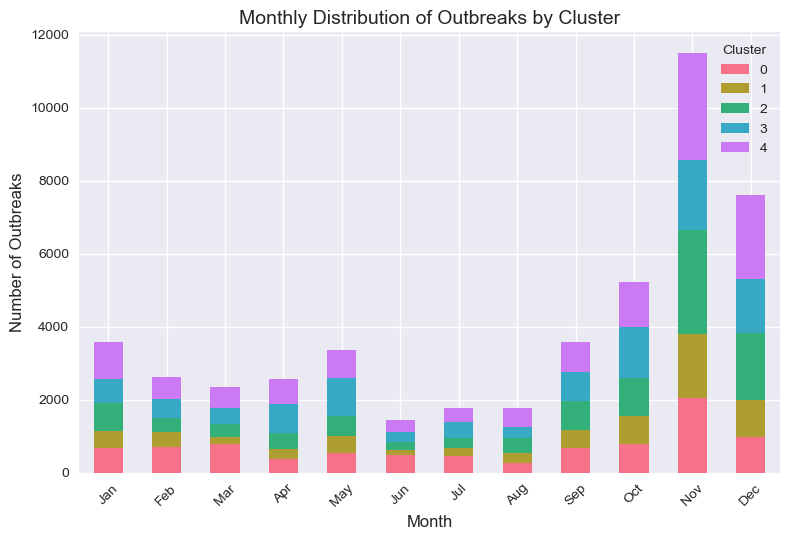

In [44]:
# 3. Temporal Distribution by Cluster
outbreak_locations['Month'] = outbreak_locations['Outbreak Date'].dt.month
monthly_cluster_counts = outbreak_locations.groupby(['Month', 'Cluster']).size().unstack()

plt.figure(figsize=(15, 8))
monthly_cluster_counts.plot(kind='bar', stacked=True, color=colors)
plt.title('Monthly Distribution of Outbreaks by Cluster', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Outbreaks', fontsize=12)
plt.legend(title='Cluster')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
           rotation=45)
plt.tight_layout()
plt.show()

In [45]:
# Calculate and display cluster statistics
cluster_stats = outbreak_locations.groupby('Cluster').agg({
    'State': lambda x: len(x.unique()),
    'County': 'count',
    'Longitude': ['mean', 'std'],
    'Latitude': ['mean', 'std']
}).round(2)

cluster_stats.columns = ['Unique States', 'Total Outbreaks', 
                        'Mean Longitude', 'Std Longitude',
                        'Mean Latitude', 'Std Latitude']

print("Cluster Statistics:")
print(cluster_stats)

# Save results
# outbreak_locations.to_csv('outbreak_clusters_analysis.csv', index=False)

Cluster Statistics:
         Unique States  Total Outbreaks  Mean Longitude  Std Longitude  \
Cluster                                                                  
0                   36             8742          -78.38           5.13   
1                   36             6458         -117.52           4.94   
2                   37             9957          -89.03           6.46   
3                   35            10083          -95.96           4.99   
4                   34            12144          -88.20           5.24   

         Mean Latitude  Std Latitude  
Cluster                               
0                41.46          1.93  
1                42.87          4.04  
2                31.93          2.05  
3                42.70          2.51  
4                37.49          1.47  


The analysis successfully grouped the outbreaks into clusters, calculated their geographic centers, identified the most affected states, and determined peak activity months. Below is the detailed cluster analysis and a visualization of their geographic distribution.